Pega a base de dados e organiza em safras, calcula o ganho de informação de cada safra em relação à target (seu ganho de informação vai ser o retorno individual de cada VP). 

1 - Tenha um dataframe massivo (com N colunas e uma target)

2 - Verifique pela Correlação de spearman as vps que são altamente correlacionadas com relação à variável resposta. 

3 - Crie grupos com base na similaridade da correlação calculada no passo 2 

4 - Avalie se existe diferença de performance entre os grupos

5 - Ordene os datasets de cada grupo por data, treine modelos e colha as performances. A performance será o retorno e o risco sera a variabilidade dessa performance.

6 - Aplique Markowitz para definir a fronteira eficiente

7 - Defina a alocação ótima como maior retorno dado o menor risco possível 

8 - Com a alocação ótima, selecione aleatoriamente VPs dentro de cada grupo

9 - Faça o Modelo com essas vps e mensure o ganho.

In [ ]:
#pip install Boruta

In [ ]:
import pandas as pd
import math
from numpy.random import rand
from numpy.random import seed
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
from functools import reduce
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import Bounds,  minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import seaborn as sns 
import random
import time
import os
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
import requests
#from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier


#1 - Criando Conjunto de Dados Simulado

In [ ]:
def gera_data_frame(n,p,m,q=None):
  #n = número de linhas do dataframe 
  #p = número de variáveis preditoras
  #m = limite do domínio das variáveis preditoras, sendo o mínimo igual a 1
  #q = Número de safras temporais na base de dados (default é de 30 safras por TCL)
  if q is None:
         q = n/30
  df = pd.DataFrame({'index':list(range(0,n))})
  import random
  for i in range(0,p):
    w = random.randint(1,m)
    df['v'+str(i)] = random.choices(list(range(0, w)), k=n)
  df = df.drop(['index'],axis=1)
  vp_resposta=[]
  for z in range(0,n):
    numero_aleatorio = round(random.random())
    if (numero_aleatorio ==1) & (df.sum(axis=1)> (df.sum(axis=1)).mean())[z]:
      numero_aleatorio = 1
    else:
      numero_aleatorio = 0
    vp_resposta.append(numero_aleatorio)
  df['target'] = vp_resposta
  safras = (list(range(0,q))*int(n/q))
  safras.sort(reverse=False)
  safras = safras + [max(safras)]*(n - len(safras))
  df['safra'] = safras
  return df 


##1.1 Simulação com Dataframe de 100000 observações, 1000 preditores com domínio até 200, distribuídos em 25 safras)

In [ ]:
df = gera_data_frame(10000,1000,200,25)
df.shape

(10000, 1002)

In [ ]:
df.head(5)

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v992,v993,v994,v995,v996,v997,v998,v999,target,safra
0,47,175,34,62,81,39,39,89,0,5,...,7,15,25,18,2,36,12,4,1,0
1,3,50,12,45,40,11,31,123,14,28,...,54,36,89,34,1,0,11,9,1,0
2,8,13,56,4,4,25,18,87,12,30,...,17,11,92,19,5,102,0,12,1,0
3,27,22,15,147,74,2,40,68,5,6,...,76,13,34,10,9,116,20,6,0,0
4,36,48,55,104,1,0,54,100,20,46,...,1,9,10,5,11,105,27,3,1,0


##1.2 Calculando a Correlação via Spearman e Pearson das Preditoras em relação a variável resposta

In [ ]:
#df.drop(['game_result'],axis=1).corr()
#df.corr(method= 'spearman')
target = 'target'
variaveis = df.columns.drop(['target','safra'])
correlacoes_p = []
correlacoes_s = []

for COLUNA in variaveis:
  correlacoes_p.append(np.round(df[target].corr(df[COLUNA]),2))
  correlacao, p = spearmanr(df[target], df[COLUNA])
  correlacoes_s.append(np.round(correlacao,2))
df_cor = pd.DataFrame({'Variaveis': variaveis, 'Correlacoes_S': correlacoes_s, 'Correlacoes_P': correlacoes_p})
#df_cor.sort_values(by=['Correlacoes'])
#df_cor.Correlacoes.min()
#df_cor.Correlacoes.max()
#df_cor.Correlacoes.quantile(q=0.75)
#df_cor.Correlacoes.quantile(q=0.25)
#df_cor.Correlacoes.quantile(q=0.5)


In [ ]:
df_cor.sort_values(by=['Correlacoes_S'])

,Variaveis,Correlacoes_S,Correlacoes_P
863,v863,-0.04,-0.04
31,v31,-0.02,-0.02
510,v510,-0.02,-0.02
752,v752,-0.02,-0.02
773,v773,-0.02,-0.02
...,...,...,...
978,v978,0.05,0.05
333,v333,NaN,NaN
364,v364,NaN,NaN
417,v417,NaN,NaN


In [ ]:
df_cor.sort_values(by=['Correlacoes_S'])['Correlacoes_S'].max(),df_cor.sort_values(by=['Correlacoes_S'])['Correlacoes_S'].min()

(0.05, -0.04)

##1.2.1 Estimando a Acurácia da Base Completa

In [ ]:
  entrada = time.perf_counter()
  X_train, X_test,y_train, y__test= train_test_split(df[variaveis], df[target], test_size = 0.3)
  clf = lgb.LGBMClassifier()
  clf.fit(X_train, y_train)
  predicao = clf.predict(X_test)
  acuracia_total = accuracy_score(predicao, y__test)
  acuracia_total
  saida = time.perf_counter()
  tempo = saida - entrada 
  'O algoritmo levou '+str(round(tempo,0))+' segundos para rodar com todas as variáveis preditoras, obtedo uma acurácia de '+ str(acuracia_total)+'.'

'O algoritmo levou 13.0 segundos para rodar com todas as variáveis preditoras, obtedo uma acurácia de 0.7576666666666667.'

##1.2.2 Estimando a Acurácia da Base Completa, reduzindo a dimensionalidade pelo Ganho de Informação

In [ ]:
entrada = time.perf_counter()
X_train_mutual_info, X_test_mutual_info,y_train_mutual_info, y__test_mutual_info= train_test_split(df[variaveis], df[target].to_numpy(), test_size = 0.3)
mutual_info = mutual_info_classif(X_train_mutual_info, y_train_mutual_info)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_mutual_info.columns
lista_vp_filtrada = mutual_info[mutual_info.sort_values(ascending=False)>0] #Ganho de Informação maior que zero
sel_cols = SelectKBest(mutual_info_classif, k=len(lista_vp_filtrada))
sel_cols.fit(X_train_mutual_info, y_train_mutual_info)
X_filtrado = df[X_train_mutual_info.columns[sel_cols.get_support()]]
X_train, X_test,y_train, y_test= train_test_split(X_filtrado, df[target], test_size = 0.3)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
predicao = clf.predict(X_test)
acuracia_total = accuracy_score(predicao, y_test)
saida = time.perf_counter()
tempo = saida - entrada 
'O algoritmo levou '+str(round(tempo,0))+' segundos para rodar e deixou '+str(len(lista_vp_filtrada))+' variáveis preditoras com uma acurácia de '+ str(acuracia_total)+'.'


'O algoritmo levou 74.0 segundos para rodar e deixou 531 variáveis preditoras com uma acurácia de 0.7373333333333333.'

##1.2.3 Estimando a Acurácia da Base Completa, reduzindo a dimensionalidade pelo Algoritmo de Árvores Extremamente Aleatórias

In [ ]:
entrada = time.perf_counter()
def funcao_variaveis_importantes(DADOS,varesp = 'y'):
        X = DADOS.loc [:, DADOS.columns != varesp] 
        Y = DADOS.loc [:, DADOS.columns == varesp]
        warnings.filterwarnings("ignore")
        model = ExtraTreesClassifier()
        model.fit(X,Y)
        ind = X.shape[1]
        variaveis = X.columns[0:ind]
        importancia = pd.DataFrame(variaveis)
        features = pd.DataFrame(model.feature_importances_)
        importancia['Importancia']= features
        importancia = importancia.rename(columns = {0:"Variáveis","Importancia":"Importancia"})
        return importancia.sort_values(['Importancia'], ascending=False)

lista_vp = funcao_variaveis_importantes(df,varesp = 'target')
X_filtrado = df[lista_vp[lista_vp.Importancia>0]['Variáveis'].values] #Importância maior que zero
lista_vp_filtrada = X_filtrado.columns
X_train, X_test,y_train, y_test= train_test_split(X_filtrado, df[target], test_size = 0.3)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
predicao = clf.predict(X_test)
acuracia_total = accuracy_score(predicao, y_test)
saida = time.perf_counter()
tempo = saida - entrada 
'O algoritmo levou '+str(round(tempo,0))+' segundos para rodar e deixou '+str(len(lista_vp_filtrada))+' variáveis preditoras com uma acurácia de '+ str(acuracia_total)+'.'


'O algoritmo levou 20.0 segundos para rodar e deixou 997 variáveis preditoras com uma acurácia de 0.732.'

##1.3 Criando os Grupos com base na similaridade de Correlação de Spearman

In [ ]:
entrada = time.perf_counter()

In [ ]:
df_cor = df_cor.dropna()
df_cor['fx']= pd.qcut(df_cor['Correlacoes_P'], q=3)

lista_variaveis_fx = []
for i in list((range(0,len(pd.unique(df_cor['fx']))))):
  lista_variaveis_fx.append(df_cor[df_cor['fx']==pd.unique(df_cor['fx'])[i]].Variaveis)

In [ ]:
tamanho_dos_grupos=[]
lista_de_grupos=[]
lista_variaveis_fx[0]
for i in list(range(0,len(lista_variaveis_fx))):
  lista_de_grupos.append('Grupo '+str(i))
  tamanho_dos_grupos.append(len(lista_variaveis_fx[i]))

divisao_grupos = pd.DataFrame({'Grupos':lista_de_grupos,'Tamanho do Grupo':tamanho_dos_grupos})
divisao_grupos


,Grupos,Tamanho do Grupo
0,Grupo 0,547
1,Grupo 1,292
2,Grupo 2,157


###1.3.1 Quantidade de Variáveis Preditoras Selecionadas:

In [ ]:
divisao_grupos['Tamanho do Grupo'].sum()

996

#2 - Estimando a Acurária de Cada Grupo

---------------------------------------------------------------------------------------------------------------

In [ ]:
y = df['target']
X_vetor = []
X_vetor_train = []
X_vetor_test = []
y_vetor_train = []
y_vetor_test = []
for i in list(range(0,len(lista_variaveis_fx))):
  X_vetor.append('X_'+str(i+1))
  X_vetor_train.append('X_train_'+str(i+1))
  X_vetor_test.append('X_test_'+str(i+1))
  y_vetor_train.append('y_train_'+str(i+1))
  y_vetor_test.append('y_test_'+str(i+1))

for i in list(range(0,len(lista_variaveis_fx))):
  X_vetor[i] = df[lista_variaveis_fx[i]]
  X_vetor_train[i], X_vetor_test[i],y_vetor_train[i], y_vetor_test[i]= train_test_split(X_vetor[i], y, test_size = 0.3)


In [ ]:
acuracia =[]
for i in list(range(0,len(lista_variaveis_fx))):
  clf = lgb.LGBMClassifier()
  clf.fit(X_vetor_train[i], y_vetor_train[i])
  pred = clf.predict(X_vetor_test[i])
  acuracia.append(accuracy_score(pred, y_vetor_test[i]))
divisao_grupos['Acuracia dos Grupos'] = acuracia
divisao_grupos

,Grupos,Tamanho do Grupo,Acuracia dos Grupos
0,Grupo 0,547,0.747667
1,Grupo 1,292,0.750333
2,Grupo 2,157,0.748667


----------------------------------------------------------------------------------------------------------------------------------------------------------------

#3 - Calculando os retornos e riscos

In [ ]:
retorno_grupo = []
for i in list(range(0,len(X_vetor))):
  df_x = X_vetor[0]
  df_x['safra']=df['safra']
  df_x['target']=df['target']
  clf = lgb.LGBMClassifier()
  retorno_safra = []
  id_safra = []
  for ANO in pd.unique(df_x['safra']):
    df_xx = df_x[df_x.safra==ANO]
    x_filtrado = df_xx.drop(['safra','target'], axis = 1)
    y_filtrado = df_xx.target
    x_filtrado_train, x_filtrado_test, y_filtrado_train, y_filtrado_test= train_test_split(x_filtrado, y_filtrado, test_size = 0.3)
    clf.fit(x_filtrado_train, y_filtrado_train)
    pred_filtrado =clf.predict(x_filtrado_test)
    retorno_safra.append(accuracy_score(pred_filtrado, y_filtrado_test))
    id_safra.append(ANO)
  df_retornos = pd.DataFrame({'Retorno Grupo '+str(i): retorno_safra, 'Safra': id_safra})
  retorno_grupo.append(df_retornos)
df_retornos = reduce(lambda  left,right: pd.merge(left,right,on=['Safra'],how='outer'), retorno_grupo)

In [ ]:
first_column = df_retornos.pop('Safra')
df_retornos.insert(0, 'Safra', first_column)
df_retornos

,Safra,Retorno Grupo 0,Retorno Grupo 1,Retorno Grupo 2
0,0,0.658333,0.675000,0.675000
1,1,0.733333,0.716667,0.766667
2,2,0.733333,0.716667,0.666667
3,3,0.866667,0.750000,0.783333
4,4,0.683333,0.658333,0.708333
5,5,0.700000,0.691667,0.683333
6,6,0.775000,0.700000,0.700000
7,7,0.758333,0.741667,0.658333
8,8,0.733333,0.733333,0.766667
9,9,0.725000,0.725000,0.758333


________________________________________________________________________________________________________________________________________________________________

In [ ]:
#Cálculo do retorno do portifolio
def get_portfolio_returns(returns, weights):
    return np.dot(returns.mean(), weights)
#Cálculo do risco do portifólio, considerando o desvio padrão
def get_portfolio_risk(returns, weights):
    covariances = returns.cov()
    var_risk = np.matmul(np.matmul((weights), covariances.values), weights)
    std_risk = np.sqrt(var_risk)
    return std_risk
def mount_portfolio(x , args):
    return get_portfolio_risk(args, x)
def compute_frontier(returns_range, returns_df):
    optimal_portfolios = []
    #restrição para que a soma dos pesos não ultrapasse o valor 1
    eq_constraint_proportions = {'type': 'eq', 'fun': lambda x: sum(x) - 1}
    #definição dos limites inferior e superior dos pesos em 0 e 1, respectivamente
    bounds = Bounds(ub=[1,1,1,1], lb=[0,0,0,0])
 
 
    #ponto de paprtida para o algoritmo de otimização, foram utilizados pesos igualmente distribuídos
    initial_guess = np.ones(len(returns_df.columns))*1/len(returns_df.columns)
    for value in returns_range:
        #restrição para garantir que o valor de retorno desejado será mantido
        eq_constraint_return = {'type':'eq', 'fun': lambda x : get_portfolio_returns(returns_df, x) - value}
 
        optimal_weights = minimize(mount_portfolio, x0 = initial_guess, method = 'SLSQP', 
                constraints = [eq_constraint_proportions, eq_constraint_return],
                bounds=bounds,  options={'ftol':1e-9, 'disp':False},
                args = (returns_df,))
        optimal_portfolios.append(optimal_weights)
    
    return optimal_portfolios


In [ ]:
#Definição dos patamares de retorno máximo e mínimo
real_returns = df_retornos.drop(['Safra'],axis=1)
min_return = real_returns.mean().min()
max_return = real_returns.mean().max()
def generate_random_portfolios(num_samples, returns): 
    returns_from_random_weights = []
    risks_from_random_weights = []
    weights = []
    for i in range(0, num_samples):
        random_weights = np.random.rand(len(returns.columns))
        random_weights = random_weights/np.sum(random_weights)
        weights.append(random_weights)
 
        random_return = get_portfolio_returns(returns, random_weights)
        random_risk = get_portfolio_risk(returns, random_weights)
 
        returns_from_random_weights.append(random_return)
        risks_from_random_weights.append(random_risk)
    return [risks_from_random_weights, returns_from_random_weights, weights]

Text(0.5, 0, 'Risco')

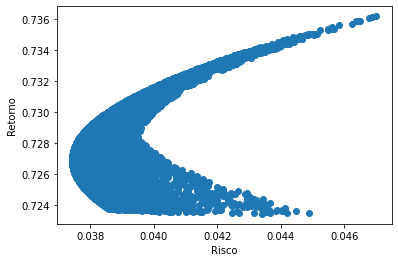

In [ ]:
random_ports = generate_random_portfolios(10000, real_returns)
plt.scatter(random_ports[0], random_ports[1])
plt.ylabel('Retorno')
plt.xlabel('Risco')

In [ ]:
fronteira_eficiente = pd.DataFrame({'Risco':random_ports[0],'Retorno':random_ports[1], 'Pesos':random_ports[2]})
fronteira_eficiente['Pesos'] = fronteira_eficiente.Pesos.apply(lambda x: np.round(x, 2))

In [ ]:
alocacao_otima = fronteira_eficiente[fronteira_eficiente.Risco ==fronteira_eficiente.Risco.min()]
alocacao_otima[['Risco','Retorno']]

,Risco,Retorno
9547,0.037421,0.726895


In [ ]:
alocacao_otima.Pesos

9547    [0.25, 0.41, 0.33]
Name: Pesos, dtype: object

----------------------------------------------------------------------------------------------------------------------------------------------------------------

# 4 - Verificar Performance da Fronteira Eficiente

In [ ]:
divisao_grupos['Alocacao Otima'] = alocacao_otima.Pesos.values[0]
divisao_grupos['Tamanho Final do Grupo'] = round((divisao_grupos['Tamanho do Grupo']*divisao_grupos['Alocacao Otima'])/divisao_grupos['Alocacao Otima'].sum(),0)
divisao_grupos

,Grupos,Tamanho do Grupo,Acuracia dos Grupos,Alocacao Otima,Tamanho Final do Grupo
0,Grupo 0,547,0.747667,0.25,138.0
1,Grupo 1,292,0.750333,0.41,121.0
2,Grupo 2,157,0.748667,0.33,52.0


In [ ]:
print('Número final de váriaveis: ',divisao_grupos['Tamanho Final do Grupo'].sum()),
print('Isso equivale à ',100*(round(1 -(divisao_grupos['Tamanho Final do Grupo'].sum()/divisao_grupos['Tamanho do Grupo'].sum()),2)),'% de redução no volume das variáveis inicias')

Número final de váriaveis:  311.0
Isso equivale à  69.0 % de redução no volume das variáveis inicias


In [ ]:
variaveis_filtradas = []
for i in list(range(0,len(X_vetor))):
  df_x = X_vetor[i]
  df_x = df_x.drop(['safra','target'],axis=1,errors='ignore')
  df_x = df_x.sample(n=int(divisao_grupos['Tamanho Final do Grupo'][i]),axis='columns')
  #df_x = df_x.sample(n=math.ceil(divisao_grupos['Alocacao Otima'][i]*df_x.shape[1]),axis='columns')
  variaveis_filtradas.extend(df_x.columns)




In [ ]:
saida = time.perf_counter()
tempo = saida - entrada 
'O Projeto levou '+str(round(tempo,0))+' segundos para rodar até essa fase.'

'O Projeto levou -93.0 segundos para rodar até essa fase.'

In [ ]:
entrada = time.perf_counter()
X_train_final, X_test_final,y_train_final, y_test_final= train_test_split(df[variaveis_filtradas], df[target], test_size = 0.3)
clf = lgb.LGBMClassifier()
clf.fit(X_train_final, y_train_final)
predicao = clf.predict(X_test_final)
acuracia_total = accuracy_score(predicao, y_test_final)
saida = time.perf_counter()
tempo = saida - entrada 
'A proposta levou '+str(round(tempo,0))+' segundos para rodar e deixou '+str(len(variaveis_filtradas))+' variáveis preditoras com uma acurácia de '+ str(round(acuracia_total,2))+'.'

'A proposta levou 12.0 segundos para rodar e deixou 311 variáveis preditoras com uma acurácia de 0.7323333333333333.'